# Offensive Rebounds vs Shot Distance

When a player takes a shot in the NBA, if the shot does not go in, either team (shooting team, or non-shooting team) can gain possession of the ball. If the non-shooting team gets the rebound (“defensive rebound”) they proceed to the other end of the court to try and make a basket. If the shooting team gets the rebound (“offensive rebound” and generally rarer) then they can try to shoot again. 

In recent years the NBA has undergone a change, focusing more on “transition offense”. That is getting a defensive rebound and pushing the ball up the court as fast a possible to score in transition. Playing fast allows the offensive team to get up the court before the defense has a chance to organize itself. 

With this change, some teams have opted to run back on defense and forego offensive rebounds, while other have opted to try to “crash the boards” and keep possesion. This is all further complicated by the fact that 3-pt shooting is on an upward trend.

Some simple questions I wanted to explore are:
1. Does the advent of the increased 3-pt shooting era lead to more offensive rebounds?
2. Which teams are looking for offensive rebounds and does this correlate with teams which focus more on 3pt shots?
3. Historically how is this trend evolving?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import requests

Why re-invent the wheel? Swar Patel already put together a nice package to extract and aquire the 
data from the stats.nba.com API endpoints (https://github.com/swar/nba_api) 

This snippet find the team_id used by the API to acquire all the game information. In this case I am looking at the 
data from the Oklahoma City Thunder

In [2]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
nba_teams = teams.get_teams()
okc = [team for team in nba_teams if team['abbreviation'] == 'OKC'][0]
thunder_id = okc['id']

Next extract and return a dataframe with all the games since 2012

In [3]:
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=thunder_id)
games = gamefinder.get_data_frames()[0]
games.groupby(games.SEASON_ID.str[-4:])[['GAME_ID']].count().loc['2012':]

,GAME_ID
SEASON_ID,
2012,105
2013,113
2014,94
2015,111
2016,98
2017,97
2018,66


Let's keep only games from 2015 onward

In [4]:
games_to_keep = games[(games.SEASON_ID.str[-4:] == '2017') | (games.SEASON_ID.str[-4:] == '2016')
                  |(games.SEASON_ID.str[-4:] == '2015') | (games.SEASON_ID.str[-4:] == '2018') ]
games_to_keep = games_to_keep.reset_index(drop=True)
games_to_keep.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22018,1610612760,OKC,Oklahoma City Thunder,0021800866,2019-02-14,OKC @ NOP,L,240,122,...,0.923,17,31,48,27,8,6,13,21,-9.0
1,22018,1610612760,OKC,Oklahoma City Thunder,0021800846,2019-02-11,OKC vs. POR,W,240,120,...,0.759,7,38,45,23,9,7,12,28,9.0
2,22018,1610612760,OKC,Oklahoma City Thunder,0021800832,2019-02-09,OKC @ HOU,W,240,117,...,0.800,12,41,53,20,7,5,19,24,5.0
3,22018,1610612760,OKC,Oklahoma City Thunder,0021800815,2019-02-07,OKC vs. MEM,W,240,117,...,0.636,11,33,44,29,17,2,11,25,22.0
4,22018,1610612760,OKC,Oklahoma City Thunder,0021800802,2019-02-05,OKC vs. ORL,W,240,132,...,0.730,8,41,49,25,11,2,17,25,10.0


Next we want to loop over all games in the list, and then get the play-by-play data. 
We want to extract and keep only important information. This involves combing through the data to get only the 
shooting and rebound data, saving the info about the team, offensive rebounds, distance, shooting percentages, and 3pt shoooting percentages. 

An example before the loop shows what this play-by-play data looks like.



In [5]:
from nba_api.stats.endpoints import playbyplayv2
from time import sleep
from dateutil import parser


first_game = games_to_keep['GAME_ID'].iloc[0]
pbp = playbyplayv2.PlayByPlayV2(first_game)
pbp = pbp.get_data_frames()[0]
pbp.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION
0,0021800866,2,12,0,1,8:03 PM,12:00,None,None,None,...,None,None,None,0,0,None,NaN,None,None,None
1,0021800866,4,10,0,1,8:03 PM,12:00,Jump Ball Davis vs. Adams: Tip to Westbrook,None,None,...,Oklahoma City,Thunder,OKC,5,201566,Russell Westbrook,1.610613e+09,Oklahoma City,Thunder,OKC
2,0021800866,7,2,1,1,8:03 PM,11:45,None,None,MISS Patterson 3PT Jump Shot,...,None,None,None,0,0,None,NaN,None,None,None
3,0021800866,8,4,0,1,8:03 PM,11:40,None,None,Adams REBOUND (Off:1 Def:0),...,None,None,None,0,0,None,NaN,None,None,None
4,0021800866,9,1,97,1,8:03 PM,11:40,None,None,Adams 1' Tip Layup Shot (2 PTS),...,None,None,None,0,0,None,NaN,None,None,None


In [6]:
# Create new dataframe with only relevant information of individual game data
allseason = pd.DataFrame(columns=['TEAM','SEA','OREBS', '0-8ft', '8-16ft','16-24ft', '24ft',
                                  '3PTPER','3PTSHOTPER', 'OREBPER', 'MISS3PTPER'])

num_games = len(games_to_keep.index)
for index, row in games_to_keep.iterrows():
    if(index % 10 == 0):
        print "parsed " + str(index) + " of " + str(num_games) + " games" 
        
    # Get the current game play-by-play data    
    current_game = games_to_keep['GAME_ID'].iloc[index]
    date_game = games_to_keep['GAME_DATE'].iloc[index]
    date_game = parser.parse(date_game).strftime("%m-%d-%Y")
    date_game=date_game[:-4]+date_game[-2:]
    sea =float(games_to_keep.SEASON_ID.str[-4:].iloc[index])
    del pbp
    pbp = playbyplayv2.PlayByPlayV2(current_game)
    pbp = pbp.get_data_frames()[0]
    pbp = pbp.drop(columns=['GAME_ID', 'WCTIMESTRING','NEUTRALDESCRIPTION', 'PERIOD','PCTIMESTRING',
          'SCORE', 'SCOREMARGIN',
          'PERSON1TYPE','PLAYER1_NAME','PLAYER1_ID','PLAYER1_TEAM_ID',
          'PLAYER1_TEAM_CITY','PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION',
          'PERSON2TYPE','PLAYER2_NAME','PLAYER2_ID','PLAYER2_TEAM_ID',
          'PLAYER2_TEAM_CITY','PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION',
          'PERSON3TYPE','PLAYER3_NAME','PLAYER3_ID','PLAYER3_TEAM_ID',
          'PLAYER3_TEAM_CITY','PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION'], axis=1)    


    # Figure out which teams' shots we want 
    desired_team = 'HOMEDESCRIPTION' 
    other_team  = 'VISITORDESCRIPTION' 
    if('@' in games_to_keep['MATCHUP'].iloc[index]):
        desired_team = 'VISITORDESCRIPTION' 
        other_team = 'HOMEDESCRIPTION' 
    
    # Store relevant info from both pbp data and game data 
    opp = str(games_to_keep['MATCHUP'].iloc[index]).split()[-1] + "\n"+ date_game
    orebs = games_to_keep['OREB'].iloc[index]
    tpp = games_to_keep['FG3_PCT'].iloc[index]
    tpsp = float(games_to_keep['FG3A'].iloc[index]) / float(games_to_keep['FGA'].iloc[index])
    oper = float(games_to_keep['OREB'].iloc[index]) /  float(games_to_keep['FGA'].iloc[index] - games_to_keep['FGM'].iloc[index])
    tpspm =  float(games_to_keep['FG3A'].iloc[index] - games_to_keep['FG3M'].iloc[index] ) /  float(games_to_keep['FGA'].iloc[index] - games_to_keep['FGM'].iloc[index])
    
    
    #Get all relevant shots, organize by distance, etc
    event_shots = (pbp[pbp[desired_team].str.contains("REBOUND") == True]['EVENTNUM']-1).tolist()
    pbp = pbp[pbp['EVENTNUM'].isin(event_shots)]
    pbp = pbp[pbp[other_team].isnull()]
    
    pbp['distance'] = pbp[desired_team].str.extract('([0-9]+)\'', expand = False)
    pbp['distance'] = pd.to_numeric(pbp['distance'], errors='coerce')
        
    pbp['shot_d_cat'] = 1
    pbp.loc[pbp['distance'] > 8, 'shot_d_cat'] = 2
    pbp.loc[pbp['distance'] > 16, 'shot_d_cat'] = 3
    pbp.loc[pbp['distance'] > 24, 'shot_d_cat'] = 4
    pbp.loc[pbp[desired_team].str.contains("3PT") == True, 'shot_d_cat'] = 4
    pbp.fillna(0.0)
       
    short = len(pbp[(pbp['shot_d_cat']==1)])
    mid = len(pbp[(pbp['shot_d_cat']==2)]) + short
    lon = len(pbp[(pbp['shot_d_cat']==3)]) + mid
    three =  len(pbp[(pbp['shot_d_cat']==4)]) 
   
    # Add to new dataframe of individual game data
    df_game = pd.DataFrame([[opp,sea,orebs,short,mid,lon,three,tpp, tpsp, oper, tpspm]],
                           columns=['TEAM', 'SEA', 'OREBS', '0-8ft','8-16ft','16-24ft','24ft',
                                    '3PTPER','3PTSHOTPER','OREBPER', 'MISS3PTPER'])
    allseason = pd.concat([df_game,allseason], sort=False)
    
    #Hacky part right now to allow requests from API to not hang up.
    if(index % 5 == 0):
        sleep(2)


parsed 0 of 372 games
parsed 10 of 372 games
parsed 20 of 372 games
parsed 30 of 372 games
parsed 40 of 372 games
parsed 50 of 372 games
parsed 60 of 372 games
parsed 70 of 372 games
parsed 80 of 372 games
parsed 90 of 372 games
parsed 100 of 372 games
parsed 110 of 372 games
parsed 120 of 372 games
parsed 130 of 372 games
parsed 140 of 372 games
parsed 150 of 372 games
parsed 160 of 372 games
parsed 170 of 372 games
parsed 180 of 372 games
parsed 190 of 372 games
parsed 200 of 372 games
parsed 210 of 372 games
parsed 220 of 372 games
parsed 230 of 372 games
parsed 240 of 372 games
parsed 250 of 372 games
parsed 260 of 372 games
parsed 270 of 372 games
parsed 280 of 372 games
parsed 290 of 372 games
parsed 300 of 372 games
parsed 310 of 372 games
parsed 320 of 372 games
parsed 330 of 372 games
parsed 340 of 372 games
parsed 350 of 372 games
parsed 360 of 372 games
parsed 370 of 372 games


In [23]:
# Remove preseason games (Games in July, August, September)
allseason = allseason[(allseason['TEAM'].str.contains("\n07") == False) 
                      & (allseason['TEAM'].str.contains("\n08") == False) 
                      & (allseason['TEAM'].str.contains("\n09") == False)]

allseason['SEA'] = allseason['SEA'].astype(int)

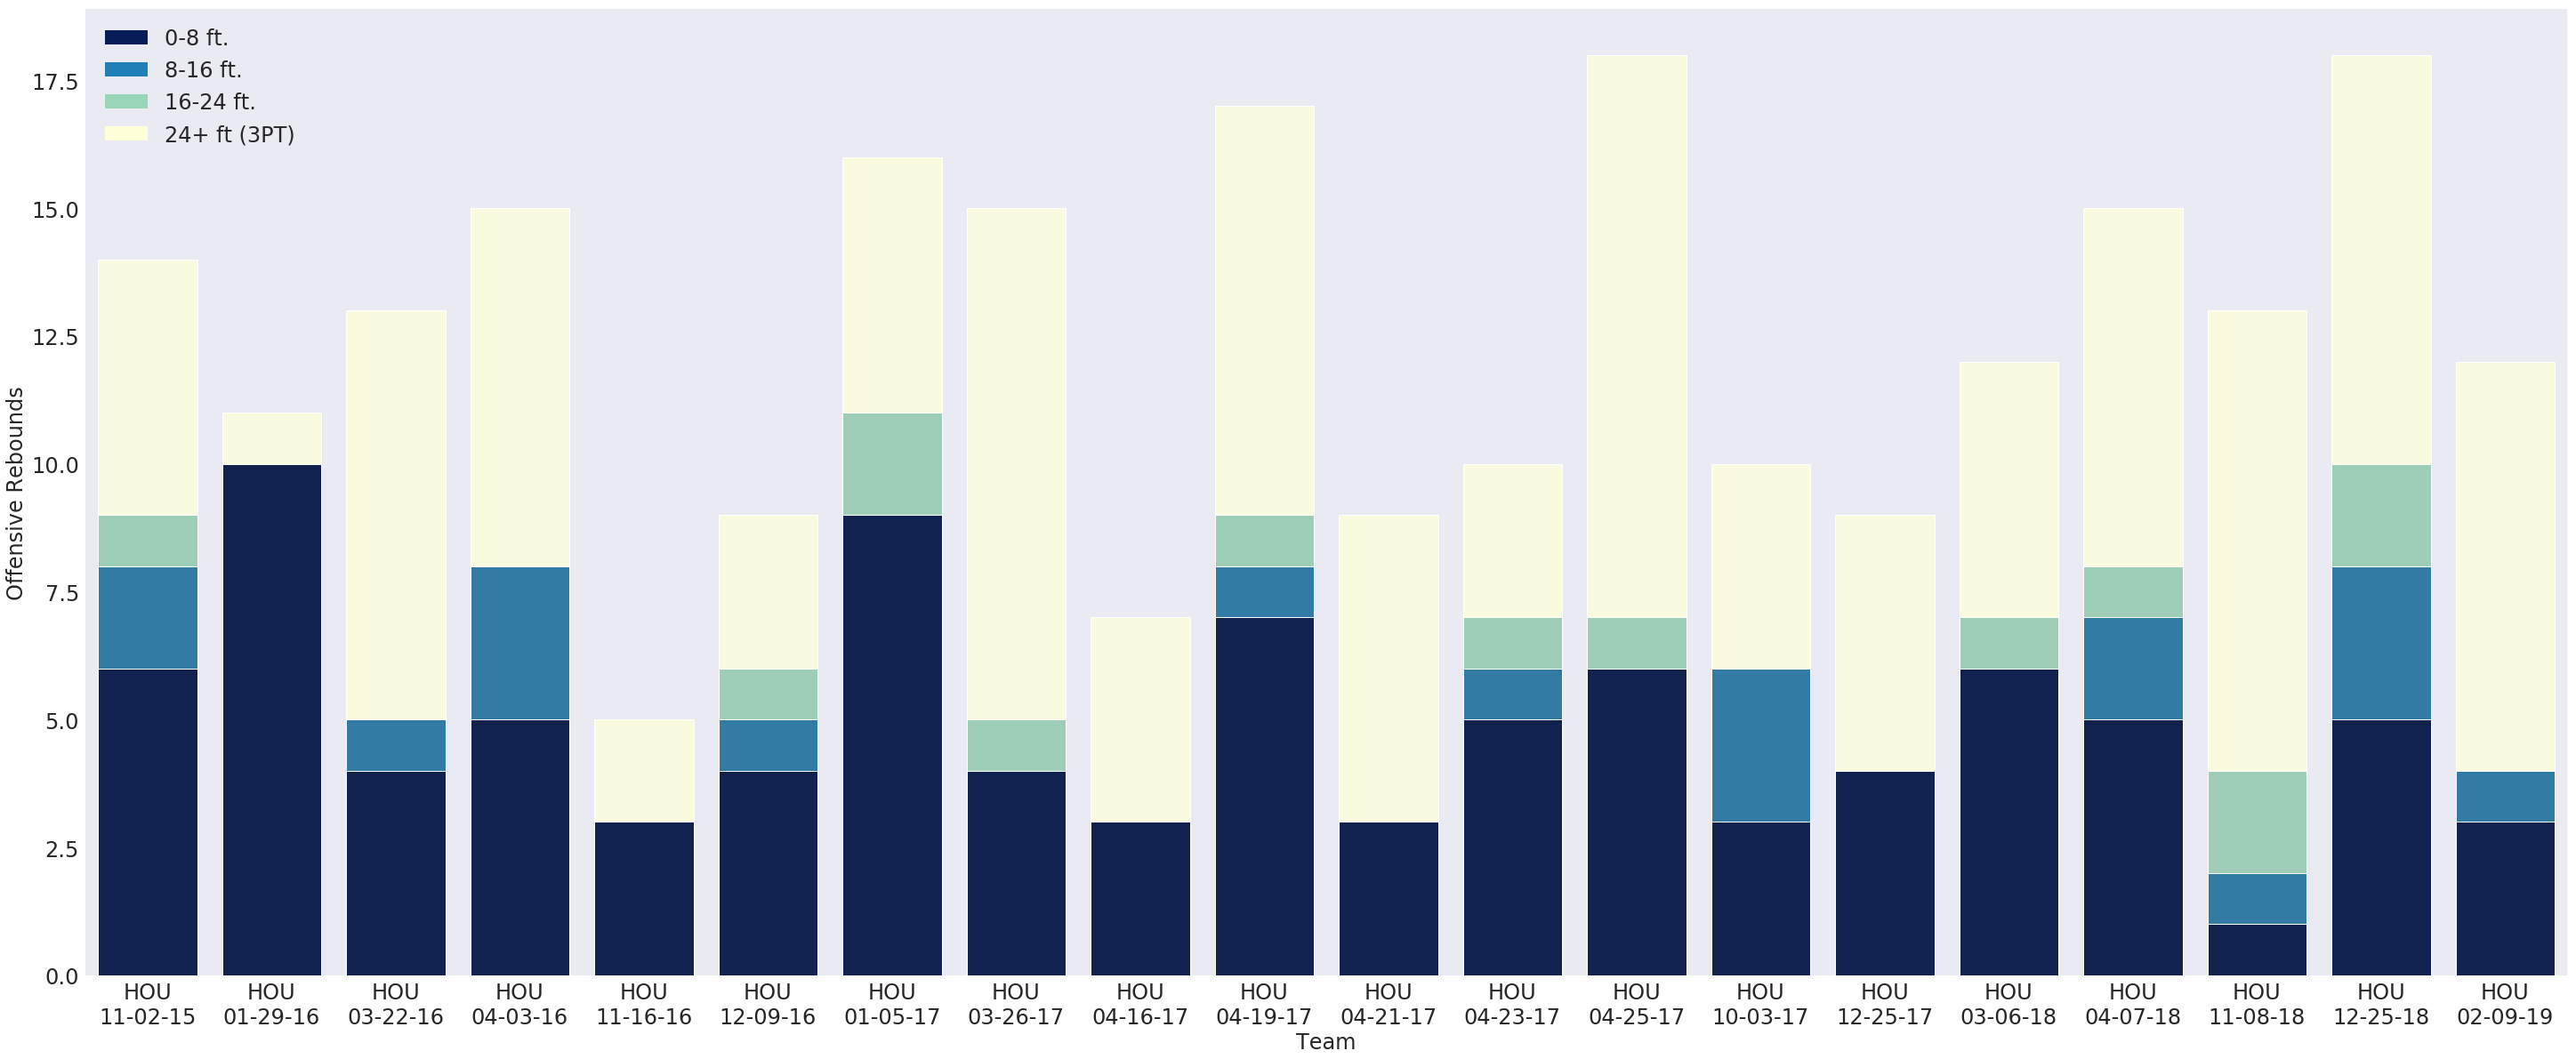

In [24]:
from matplotlib import pyplot as plt
from matplotlib import cm 

import seaborn as sns
sns.set_style("dark")
sns.set_color_codes()
plt.figure(figsize=(50,20))

hou = allseason[allseason['TEAM'].str.contains("HOU") == True]

color1=iter(cm.YlGnBu(np.linspace(0,1,4)))

c=next(color1)

sns.barplot(x = hou['TEAM'], y = hou['OREBS'],  color=c)
three_bar = plt.Rectangle((0,0),1,1,fc=c, edgecolor = 'none')
c=next(color1)

long_plot = sns.barplot(x = hou['TEAM'], y = hou['16-24ft'], color=c)
long_bar = plt.Rectangle((0,0),1,1,fc=c,  edgecolor = 'none')
c=next(color1)

mid_plot = sns.barplot(x = hou['TEAM'], y = hou['8-16ft'], color=c)
mid_bar = plt.Rectangle((0,0),1,1,fc=c, edgecolor = 'none')
c=next(color1)

short_plot = sns.barplot(x = hou['TEAM'], y = hou['0-8ft'], color=c)
short_bar = plt.Rectangle((0,0),1,1,fc=c,  edgecolor = 'none')

l = plt.legend([short_bar, mid_bar,long_bar,three_bar],
               ['0-8 ft.', '8-16 ft.','16-24 ft.', '24+ ft (3PT)'], loc=2, ncol = 1, prop={'size':24})
l.draw_frame(False)



sns.despine(left=True)
short_plot.set_ylabel("Offensive Rebounds")
short_plot.set_xlabel("Team")

for item in ([short_plot.xaxis.label, short_plot.yaxis.label] +
             short_plot.get_xticklabels() + short_plot.get_yticklabels()):
    item.set_fontsize(24)

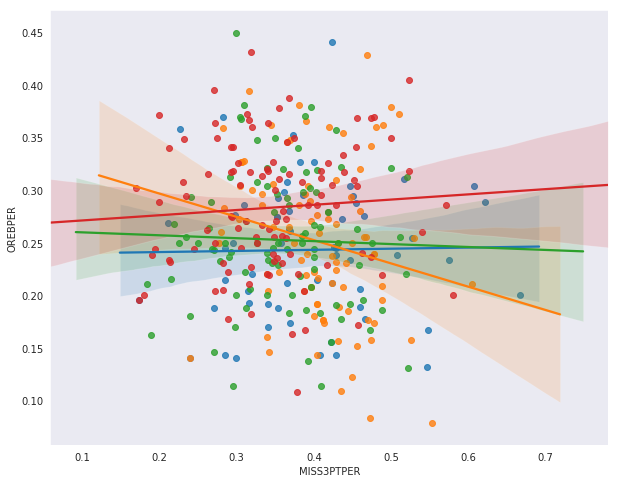

In [32]:
from matplotlib import cm 

#'3PTPER','3PTSHOTPER','OREBPER', 'MISS3PTPER'
#sns.jointplot(x,y,kind="kde",color="#4CB391")allseason[(allseason['SEA' == 2018])]

allseason['3PTOREBPER'] = allseason['24ft'].astype(float) / allseason['OREBS'].astype(float)
plt.figure(figsize=(10,8))

sea_15 = allseason[(allseason['SEA'] == 2015)]
sea_16 = allseason[(allseason['SEA'] == 2016)]
sea_17 = allseason[(allseason['SEA'] == 2017)]
sea_18 = allseason[(allseason['SEA'] == 2018)]


x=sea_18['MISS3PTPER'].astype(float)
y=sea_18['OREBPER'].astype(float)

sns.regplot(x,y)

x1=sea_17['MISS3PTPER'].astype(float)
y1=sea_17['OREBPER'].astype(float)

plot_17 = sns.regplot(x1,y1)

x2=sea_16['MISS3PTPER'].astype(float)
y2=sea_16['OREBPER'].astype(float)

plot_16 = sns.regplot(x2,y2)

x3=sea_15['MISS3PTPER'].astype(float)
y3=sea_15['OREBPER'].astype(float)

plot_15 = sns.regplot(x3,y3)


In [40]:
allseason.head()
allseason.dtypes
#plt.figure(figsize=(10,8))
#x=allseason['3PTOREBPER']
#y=allseason['OREBS']
#sns.jointplot(x, y, kind="hex", color="#4CB391")
#sns.jointplot(x, y, kind="reg",color="blue")

TEAM           object
SEA            object
OREBS          object
0-8ft          object
8-16ft         object
16-24ft        object
24ft           object
3PTPER        float64
3PTSHOTPER    float64
OREBPER       float64
MISS3PTPER    float64
3PTOREBPER    float64
dtype: object

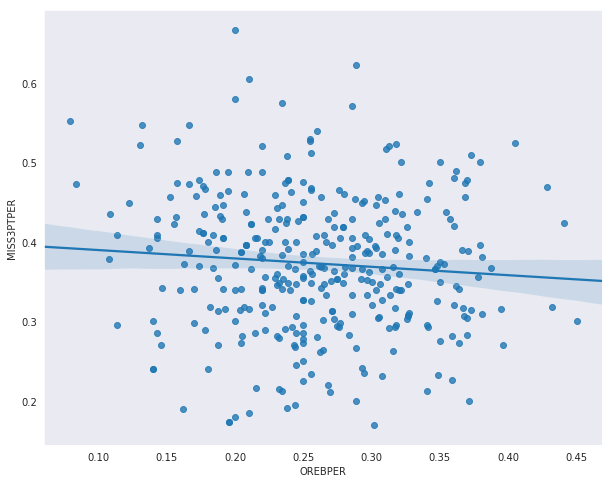

In [64]:
plt.figure(figsize=(10,8))
sns.plot(x=allseason['OREBPER'], y=allseason['MISS3PTPER'])